<a href="https://colab.research.google.com/github/ACollinsDev/Sandbox/blob/master/RT_Model_Alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU RAM allocated

In [0]:
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
#import psutil
#import humanize
#import os
#import GPUtil as GPU
#GPUs = GPU.getGPUs()
#XXX: only one GPU on Colab and isn’t guaranteed
#gpu = GPUs[0]
#def printm():
#    process = psutil.Process(os.getpid())
#    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
#printm()

# Check TPU Specifications (if activated)

In [0]:
#import os
#import pprint
#import tensorflow as tf

#if 'COLAB_TPU_ADDR' not in os.environ:
#    print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
#else:
#    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
#    print ('TPU address is', tpu_address)

#    with tf.Session(tpu_address) as session:
#        devices = session.list_devices()
    
#    print('TPU devices:')
#    pprint.pprint(devices)

**Configure TPU**

In [0]:
#use_tpu = True #@param {type:"boolean"}

#if use_tpu:
#    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

#if 'COLAB_TPU_ADDR' in os.environ:
#  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
#else:
#  TF_MASTER=''

#with tf.Session(TF_MASTER) as session:
#  print ('List of devices:')
#  pprint.pprint(session.list_devices())

# Tensorboard Config

**Unpack Ngrok**

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-06-27 02:05:04--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.226.180.131, 35.169.95.168, 35.172.177.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.226.180.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17556757 (17M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  16.74M  15.3MB/s    in 1.1s    

2019-06-27 02:05:06 (15.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [17556757/17556757]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


**Start Tensorboard**

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

**Start Ngrok**

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

**Retrieve URL for Tensorboard**

In [0]:
#click on link generated to open Tensorboard
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://4375006d.ngrok.io


**HDF5 Support for Model Checkpoints**

In [0]:
#!pip install h5py

In [1]:
#tensorflow specific libraries
import tensorflow as tf
from tensorflow.python.data import Dataset
import keras
from keras        import metrics, backend as k
from keras.layers import Input, Dense, Activation, Flatten, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from keras.models import Sequential, load_model
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras        import initializers

#tf.enable_eager_execution() #tf.placeholder not compatible with eager execution, used for autoencoder

tf.logging.set_verbosity(tf.logging.ERROR) #sets threshold for what is logged in tenserflow

Using TensorFlow backend.


**Clear Tensorboard Records Directory**

In [0]:
!rm -rf log

# Colaboratory Config

**Import Libraries and Methods**

In [0]:
from __future__ import division #import python 3 updates for floating point division
from __future__ import print_function

import os
import math

from IPython.display import Audio
from scipy.io import wavfile
from scipy import signal
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

import datetime
import numpy as np
from numpy import mean, sqrt, square, arange, fft
import random
import numpy.random 
from sklearn import metrics

**Google Drive Configuration**

In [0]:
#!google-drive-ocamlfuse -cc  #if need to clear virtual machine cache, when added files are put into google drive, time consuming so use carefully

In [3]:
from google.colab import auth
from google.colab import files

#email Collins.AE6@gmail.com
#pswd machine_learning610

from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

#Upload data from GoogleDrive
gDrive= '/content/drive/My Drive/Training_Database/gaussian_database_2/speech_single_talker_32/'
#gDrive= '/content/drive/My Drive/Training_Database/gaussian_database_1/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Audio File Processing

In [0]:
#check for data
!ls "/content/drive/My Drive/Training_Database/gaussian_database_2/speech_single_talker_32" #"/content/drive/My Drive/Training_Database/Envelope/"

 20000_1_32_best_model.h5
 20000_13_32_best.h5
 20000_13_32_OG.h5
'20 000 13 speakers 32 bit ep 89 MSE 02213 .h5'
'20000 13_speakers_50Stride_00892MSE.h5'
'20000 1_speaker_50stride_012MSE.h5'
'20 000 1 speaker ep 72 MSE 01336 .h5'
 test_database_convolved_speech_100_13_32.npy
 test_database_convolved_speech_100_32.npy
 test_database_rt_random_100_13_32.npy
 test_database_rt_random_100_32.npy
 training_database_convolved_speech_20000_13_32.npy
 training_database_convolved_speech_20000_32.npy
 training_database_rt_random_20000_13_32.npy
 training_database_rt_random_20000_32.npy
 validation_database_convolved_speech_4000_13_32.npy
 validation_database_convolved_speech_4000_32.npy
 validation_database_rt_random_4000_13_32.npy
 validation_database_rt_random_4000_32.npy


**Load databases**

In [0]:
#load convolved speech databases
#training database
#training = gDrive+'training_database_convolved_speech_10000.npy'
training = gDrive+'training_database_convolved_speech_20000_32.npy'
training_database_convolved_speech = np.load(training)

#load reverberation time database
training_rt = gDrive+'training_database_rt_random_20000_32.npy'
training_database_rt_random = np.load(training_rt)

In [0]:
#test_database_rt_random.shape

In [0]:
#validation database
validation = gDrive+'validation_database_convolved_speech_4000_32.npy'
validation_database_convolved_speech = np.load(validation)

validation_rt_random = gDrive+'validation_database_rt_random_4000_32.npy'
validation_database_rt_random = np.load(validation_rt_random)

In [0]:
#test database
test = gDrive+'test_database_convolved_speech_100_32.npy'
test_database_convolved_speech = np.load(test)

test_rt = gDrive+'test_database_rt_random_100_32.npy'
test_database_rt_random = np.load(test_rt)

In [0]:
#test = gDrive+'training_database_convolved_speech_1500.npy'
#test_database_convolved_speech = np.load(test)

In [0]:
#load gaussian impulse response database
#training_gaus = gDrive+'training_database_gaussian_impulse_1500.npy'
#training_database_gaus = np.load(training_gaus)

#validation_gaus = gDrive+'validation_database_gaussian_impulse_150.npy'
#validation_database_gaus= np.load(validation_gaus)

#test_gaus = gDrive+'test_database_gaussian_impulse_50.npy'
#test_database_gaus = np.load(test_gaus)

In [0]:
fs = 16000
#Audio(training_database_convolved_speech[25], rate=fs)

# Convolution Neural Network

**Format Datasets For Convolution**

In [0]:
training_database_convolved_speech.shape

(20000, 64000, 1)

In [0]:
number_of_features = 1 #feature number for CNN input, since univariant time series only 1 feature
cnn_sequence_length = 4*16000 #timesteps for CNN nextwork per sample, map over each entire sample

input_database = training_database_convolved_speech
#input_database = input_database[:,:,np.newaxis]
output_database = training_database_rt_random
#output_database = training_database_gaus

validation_input = validation_database_convolved_speech
#validation_input = validation_input[:,:,np.newaxis]

validation_output = validation_database_rt_random
#validation_output = validation_database_gaus

In [0]:
test_input = test_database_convolved_speech
#test_input = test_input[:,:,np.newaxis]

In [0]:
#plt.plot(validation_input[0])

# Neural Network Configuration

**Declare Model Type**

In [0]:
model = Sequential() #stacked layers of neural network

In [0]:
# This address identifies the TPU we'll use when configuring TensorFlow.
#TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
#tf.logging.set_verbosity(tf.logging.INFO)

#tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#    model,
#    strategy=tf.contrib.tpu.TPUDistributionStrategy(
#        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

Convert Model To TPU model

**Convolution Layer #1**

In [0]:
#adds a 1D convolutional layer, 1 dimension (temporal) on raw audio
#config is 32 output chanels, 
#kernal size is 5x5 moving window, 
#strides in x and y directions (1,1)
#rectilinear activation function, provide size of input to the layer, size only required for first 
#layer after that keras can calculate size of tensors
#in keras don't need to declare weights or biases variables, done for you with program

model.add(Conv1D(128, 
                 kernel_size=8,        #setup window size to be equal to strides for no overlap    
                 strides=4,            #8 gives 25ms stride window with 16kHz sampling rate gives a window ever 400 points for a total of 240 windows.     
                 activation='relu',           #rectilinear activation function
                 kernel_initializer = initializers.he_normal(seed=None),  #used to keep variance between weights and input similar, truncated normal distribution centered at 0, seed used for random generator 
                 bias_initializer = initializers.Constant(0.2),
                 input_shape=(cnn_sequence_length,number_of_features))) #training_data.shape[0]) input_shape = (img_x, img_y, 1)

#model.add(BatchNormalization())
#model.add(Activation='relu')

**Convolution Layer #2**

In [0]:
model.add(Conv1D(32, 
                 kernel_size=32,        #setup window size to be equal to strides for no overlap    
                 strides=16,            #32 gives 25ms stride window with 16kHz sampling rate gives a window ever 400 points for a total of 240 windows.     
                 activation='relu',
                 kernel_initializer = initializers.he_normal(seed=None),  #used to keep variance between weights and input similar, truncated normal distribution centered at 0, seed used for random generator 
                 bias_initializer = initializers.Constant(0.2)))           #rectilinear activation function

**Convolution Layer #3**

In [0]:
#model.add(Conv1D(32,                     #orginally 16
#                 kernel_size=80,        #setup window size to be equal to strides for no overlap    
#                 strides=80,            #25ms stride window with 16kHz sampling rate gives a window ever 400 points for a total of 240 windows.     
#                 activation='relu'))          #rectilinear activation function
                                              #shape is tracked in Keras after initializing so no need to specify input shape again.  
#model.add(BatchNormalization())
#model.add(Activation('relu'))

**Pooling Layer #2**

In [0]:
model.add(MaxPooling1D(pool_size=(2), strides=(2))) #setup pooling layer, size of pooling in x, y dimensions and strides in x,y
#model.add(Dropout(0.5))

**Flatten Pooling Layers & Connect To Fully Connected Layer**

In [0]:
model.add(Flatten())

**Inner Dense Layer #1**

In [0]:
model.add(Dense(1000, 
                activation='relu',
                kernel_initializer = initializers.he_normal(seed=None),  #used to keep variance between weights and input similar, truncated normal distribution centered at 0, seed used for random generator 
                bias_initializer = initializers.Constant(0.2))) #initalized to reduce likelihood of inactive ReLU activations
model.add(Dropout(0.5))

Inner Dense Layer #2

In [0]:
#model.add(Dense(1000, 
#                activation='relu',
#                kernel_initializer = initializers.he_normal(seed=None),  #used to keep variance between weights and input similar, truncated normal distribution centered at 0, seed used for random generator 
#                bias_initializer = initializers.Constant(0.1))) #initalized to reduce likelihood of inactive ReLU activations
#model.add(Dropout(0.2))

**Output Dense Layer**

In [0]:
#RT model
model.add(Dense(1000, 
                activation='relu',
                kernel_initializer = initializers.he_normal(seed=None),  #used to keep variance between weights and input similar, truncated normal distribution centered at 0, seed used for random generator 
                bias_initializer = initializers.Constant(0.2))) #initalized to reduce likelihood of inactive ReLU activations
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(Activation('relu')
model.add(Dense(1, activation='linear'))#gives one linear output layer for regression, if classification typically Dense(num_classes, activation='softmax'))

#IR model
#model.add(Dense(100000, activation='relu'))
#model.add(Dense(4*16000, activation='linear')) #gives one linear output layer for regression, if classification typically Dense(num_classes, activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 15999, 128)        1152      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 998, 32)           131104    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15968)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              15969000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
__________

# Training Model

**Compile Network**

In [0]:
#K <- backend()

#metric_cor <- function(y_true, y_pred) [
#  n <- K.sum(K.ones_like(y_true))
#  sum_x <- K.sum(y_true)
#  sum_y <- K.sum(y_pred)
#  sum_x_sq <- K.sum(K.square(y_true))
#  sum_y_sq <- K.sum(K.square(y_pred))
#  psum <- K.sum(y_true * y_pred)
#  num <- psum - (sum_x * sum_y / n)
#  den <- K.sqrt((sum_x_sq - K.square(sum_x) / n) *  (sum_y_sq - K.square(sum_y) / n))
  
#  num / den
#]

In [0]:
model.compile(loss=keras.losses.mean_squared_error, #defines loss function and optimizer, standard cross entropy for categorical class classification #categorical_crossentropy
              optimizer=keras.optimizers.Adam(lr=0.00001), #default learning rate is 0.001
              metrics=['mean_squared_error'])                       #specifies a metric that will be calculated during operation, ['accuracy'] useful for classification but not regression
              #metrics= ["corr" = metric_corr])

**Convert Model to TPU Format**

In [0]:
#tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#    model,
#    strategy=tf.contrib.tpu.TPUDistributionStrategy(
#        tf.contrib.cluster_resolver.TPUClusterResolver(TF_MASTER)))

#tpu_model.compile(
#    optimizer=tf.train.AdamOptimizer(learning_rate=0.00001, ),
#    metrics=['mean_squared_error']
#)

**Early Stopping**

In [0]:
# simple early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

**Model Checkpoint**

In [0]:
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
#for TPU

#model.compile(
#        optimizer=tf.train.Adam(learning_rate=0.0001), #Keras optimizer configuration with TPU still experimental so use TensorFlow for now as of 2019.04.19
#        loss='mean_squared_error',
#        metrics=['mse'])

**Hyperparameters**

In [0]:
batch_size = 16
epochs = 100 #of iterations

**Tensorboard Parameter Config**

In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size)

**Fit Model & Training Parameters**

In [0]:
model.fit(x=input_database,                        #pass in all training data, next define batch, training epochs, verbose defines what info is printed, x = input, y = output you are training model to output
          y=output_database,
          batch_size=batch_size,                   #pass validation or test data to the fit function so Keras knows what data to test metric against when evaluate is run on model
          epochs=epochs, 
          verbose=2,                               #show realtime processing, =0 for no updates, =1 for progress bar =2 one line per epoch
          #validation_split=0.5,                    #fraction of input_database used for training vs validation
          validation_data = (validation_input, validation_output),
          callbacks=[tbCallBack, early_stopping, model_checkpoint])             #feeds model calculations to tensor board and activates early stopping

In [0]:
#score = model.evaluate(output_database, , verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])
#plt.plot(range(1, 11), history.acc)
#lt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.show()

# Test Model

**Load Best Trained Model**

In [0]:
#best_model = load_model('best_model.h5')

**Reload Saved Model**

In [0]:
#test database
test = gDrive+'test_database_convolved_speech_100_13_32.npy'
test_database_convolved_speech = np.load(test)

test_rt = gDrive+'test_database_rt_random_100_13_32.npy'
test_database_rt_random = np.load(test_rt)

test_input = test_database_convolved_speech

b_model = gDrive+'20000 13_speakers_50Stride_00892MSE.h5'

best_model = load_model(b_model)

**RT predictions with trained CNN**

In [42]:
rt_predictions = best_model.predict(test_input, verbose=1)

#rt_predictions = np.around(rt_predictions,1)

#print(rt_predictions)

100/100 [==============================] - 0s 4ms/step


In [0]:
#length = 1500 #number RT predictions
#number_of_rt = np.linspace(0,length,length)

In [0]:
#plt.scatter(number_of_rt,rt_predictions, label = 'RT_Predictions', color = 'red', alpha = 0.5)
#plt.scatter(number_of_rt,test_database_rt_random, label = 'RT_answers', color = 'blue', alpha = 0.5)
#plt.show()

In [0]:
#from scipy.stats import pearsonr
# calculate Pearson's correlation
#corr, _ = pearsonr(rt_predictions, test_database_rt_random)
#print('Pearsons correlation %.3f' % corr)
	
#Pearsons correlation: 0.888

In [0]:
rt_predictions_compressed = rt_predictions.flatten()  #format predictions for comparison to ground truth

In [0]:
event_line= np.linspace(0.5,2,num=2)
#event_line_1= np.linspace(0.5,1,num=2)
#event_line_2= np.linspace(1,2,num=2)

event_line_limen_positive = event_line*1.05 #event_line*1.05 #[0.53, 2.1] 
event_line_limen_negative = event_line*0.95 #event_line*0.95 #[0.47, 1.9]

event_line_measurement_positive = event_line*1.10 #event_line*1.10 #[0.6, 2.2]
#event_line_measurement_positive_2 = [1.1, 2.2] #event_line*1.10 #[0.6, 2.2]
event_line_measurement_negative = event_line*0.90 #event_line*0.90 #[0.4, 1.8]
#event_line_measurement_negative_2 = [0.9, 1.8] #event_line*0.90 #[0.4, 1.8]

#event_line_limen = np.append(event_line_limen_positive, event_line_limen_negative)

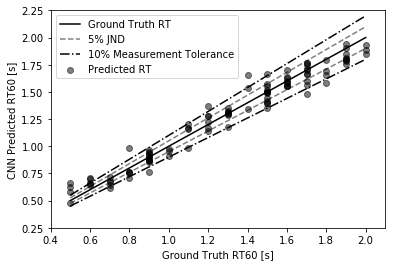

In [45]:
plt.scatter(test_database_rt_random,rt_predictions_compressed, label = 'Predicted RT', color= 'black', alpha = 0.5)
plt.plot(event_line, event_line, label = 'Ground Truth RT', color = 'black')

#difference limen 5% tolerance
plt.plot(event_line, event_line_limen_positive, label = '5% JND', color = 'black', alpha = 0.5, linestyle ='dashed')
plt.plot(event_line, event_line_limen_negative, color = 'black', alpha = 0.5, linestyle ='dashed')

#measurement uncertainty 10% tolerance
plt.plot(event_line, event_line_measurement_positive,  label = '10% Measurement Tolerance', color = 'black', linestyle ='-.')
plt.plot(event_line, event_line_measurement_negative, color = 'black', linestyle ='-.')
#plt.plot(event_line_2, event_line_measurement_positive_2, color = 'black', linestyle ='-.')
#plt.plot(event_line_2, event_line_measurement_negative_2, color = 'black', linestyle ='-.')

plt.xlim(0.4,2.1)
plt.ylim(0.25,2.25)
#display settings
plt.ylabel('CNN Predicted RT60 [s]')
plt.xlabel('Ground Truth RT60 [s]')
plt.legend()

#plt.grid()
plt.show()

In [0]:
error_inspect = rt_predictions_compressed-test_database_rt_random

In [0]:
np.savetxt('error_inspect.txt', error_inspect, delimiter=',')
#np.savetxt('rt_testset.txt', test_database_rt_random, delimiter=',')

In [0]:
files.download('error_inspect.txt')
#files.download('rt_testset.txt')

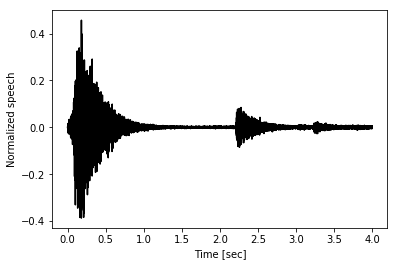

In [32]:
framerate = 16000 #match sample frequency of wav file [Hz]
length = 4 #duration in [s]
t = np.linspace(0,length,length*framerate)
plt.plot(t,test_input[4], color='black')
plt.ylabel('Normalized speech')
plt.xlabel('Time [sec]')
Audio(test_input[4,:,0],rate=16000)

In [0]:
Audio(test_input[35,:,0],rate=16000)

In [0]:
test_input.shape

In [0]:
#numpy.savetxt("raw data.csv", rt_predictions_compressed, delimiter=",")
#numpy.savetxt("ground truth data.csv", prediction_database_rt_random, delimiter=",")

In [0]:
bin_size = 0.1; min_edge = 0.5; max_edge = 2.5
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

plt.hist(rt_predictions, label = 'RT_Predictions', color = 'red', alpha = 0.5, bins=bin_list)
plt.hist(test_database_rt_random, label = 'RT_answers', color = 'blue', alpha = 0.5, bins=bin_list)
plt.show()

In [0]:
error = rt_predictions_compressed - test_database_rt_random
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [RT60]")
_ = plt.ylabel("Count")

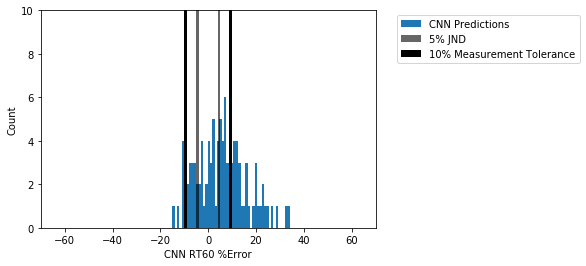

In [18]:
error = -(1-rt_predictions_compressed/test_database_rt_random)*100
limen_error = [-5, 5, -5, 5, -5, 5, -5, 5, -5, 5, -5, 5, -5, 5, -5, 5, -5, 5, -5, 5]
measurement_error = [-10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10]
plt.hist(error, bins = 50, label = 'CNN Predictions')
plt.hist(limen_error, bins = 10, color='black', label = '5% JND', alpha = 0.6)
plt.hist(measurement_error, bins = 15, color='black', label = '10% Measurement Tolerance')
plt.xlabel("CNN RT60 %Error")
plt.xlim(-70,70)
plt.ylim(0,10)
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2) #bbox_to_anchor=(1.05, 1), loc=2

In [0]:
#plt.hist(rt_predictions-prediction_database_rt_random, label = 'Delta')
#plt.show()

In [0]:
tf.keras.backend.clear_session()
k.clear_session()
del model

# Filter Visualizations

In [0]:
from keras.utils import plot_model
plot_model(best_model, to_file='model.png')

In [0]:
weights = best_model.get_weights()

In [0]:
weights_array = np.asarray(weights)

In [0]:
weights_array[0].shape

In [0]:
weights_first_layer = weights_array[0]

In [0]:
weights_first_layer[0,0,:]

In [0]:
plt.plot(weights_first_layer[0,0,:], color='black')

In [0]:
t = np.arange(16)
real = np.fft.fft(weights_first_layer[0,0,:])
freq = np.fftfreq(t.shape[-1])
plt.plot(freq, real.real)

In [0]:
import scipy.fftpack
# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
#x = np.linspace(0.0, N*T, N)
y = weights_first_layer[0,0,:]
yf = scipy.fftpack.fft(y)
#xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
plt.plot(yf.real)
#fig, ax = plt.subplots()
#ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [0]:
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
dB_spectrum = 20*np.log10(Sxx/np.max(Sxx))
cmap = plt.get_cmap('viridis') #winter, summer, grey, hot
plt.pcolormesh(t, f, dB_spectrum, cmap=cmap, vmin=-100) # norm=LogNorm(vmin=Sxx.min(),vmax=Sxx.max() Sxx.min() 10**-8
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
#plt.ylim(50,8000)
#plt.xlim(0,4)
plt.show()